In [25]:
import logging
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger

from neural_bandits.bandits.combinatorial_neural_ucb import CombinatorialNeuralUCBBandit
from neural_bandits.benchmark.datasets.abstract_dataset import AbstractDataset
from neural_bandits.benchmark.environment import BanditBenchmarkEnvironment
from neural_bandits.benchmark.logger_decorator import OnlineBanditLoggerDecorator
from neural_bandits.utils.data_storage import InMemoryDataBuffer, AllDataBufferStrategy, SlidingWindowBufferStrategy
from IPython.display import display, clear_output

In [26]:
class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

class LinearNetwork(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, 1)

    def forward(self, x):
        return self.fc(x)

In [27]:
class SyntheticCombinatorialDataset(AbstractDataset):
    """Synthetic dataset for Combinatorial Neural Bandit experiments.
    
    Implements the score functions from Hwang et al. "Combinatorial Neural Bandits" (section 5):
    - Linear: h₁(x) = x^T a
    - Quadratic: h₂(x) = (x^T a)²
    - Cosine: h₃(x) = cos(πx^T a)
    
    where a is a random vector generated from a unit ball.
    
    The dataset generates contexts and rewards according to the chosen function type.
    Each sample consists of a set of N arms, each with its own context vector.
    The reward for each arm is computed based on the chosen function.
    """
    
    def __init__(self, 
                 n_samples: int = 10000, 
                 n_arms: int = 20, 
                 context_dim: int = 40, 
                 function_type: str = "linear",
                 noise_std: float = 0.1,
                 seed: int = 42):
        """Initialize the synthetic dataset.
        
        Args:
            n_samples: Number of samples in the dataset
            n_arms: Number of arms in each sample
            context_dim: Dimension of context vector
            function_type: Type of score function to use ('linear', 'quadratic', 'cosine')
            noise_std: Standard deviation of Gaussian noise added to rewards
            seed: Random seed for reproducibility
        """
        super().__init__(needs_disjoint_contextualization=False)
        
        self.n_samples = n_samples
        self.num_actions = n_arms  # required by AbstractDataset
        self.context_size = context_dim  # required by AbstractDataset
        self.function_type = function_type
        self.noise_std = noise_std
        
        # Set random seed for reproducibility
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # Generate random vector a for score function
        # This is the parameter vector used in all three function types
        self.a = self._random_unit_ball(1)[0]
        
        # Generate context vectors for all samples and arms
        # Each context is randomly generated from a normal distribution
        self.contexts = self._random_unit_ball(n_samples * n_arms).reshape(n_samples, n_arms, context_dim)
        
        # Compute rewards based on the chosen function
        self.rewards = self._compute_rewards()
        
        # Add Gaussian noise to rewards
        if noise_std > 0:
            noise = torch.randn_like(self.rewards) * noise_std
            self.rewards = self.rewards + noise
            # Clip rewards to [0, 1] range
            # self.rewards = torch.clamp(self.rewards, 0, 1)
    
    def _random_unit_ball(self, n_samples: int) -> torch.Tensor:
        """Generate random vectors from a unit ball of dim=context_size.
        
        Args:
            n_samples: Number of vectors to generate
            
        Returns:
            Tensor of random vectors. Shape: (n_samples, dim)
        """
        # Step 1: Sample from standard Gaussian: shape (num_points, d)
        x = torch.randn(n_samples, self.context_size)
        # Step 2: Normalize each row to get a direction vector
        directions = x / x.norm(dim=1, keepdim=True)
        # Step 3: Sample radii that accounts for the d-dimensional volume distribution
        u = torch.rand(n_samples, 1)
        radii = u.pow(1.0 / self.context_size)
        # Scale the directions by the radii to get samples in the unit ball.
        return directions * radii

    def _compute_rewards(self) -> torch.Tensor:
        """Compute rewards based on the chosen function type.
        
        Returns:
            Tensor of rewards for all samples and arms. Shape: (n_samples, n_arms)
        """
        # Inner product between contexts and a
        inner_prod = torch.matmul(self.contexts, self.a)
        
        if self.function_type == "linear":
            # h₁(x) = x^T a
            # Scale to [0, 1] range
            # return 0.5 * (inner_prod + 1)
            return inner_prod
        elif self.function_type == "quadratic":
            # h₂(x) = (x^T a)²
            return inner_prod**2
        elif self.function_type == "cosine":
            # h₃(x) = cos(πx^T a)
            # Scale to [0, 1] range
            return 0.5 * (torch.cos(np.pi * inner_prod) + 1)
        else:
            raise ValueError(f"Unknown function type: {self.function_type}")
    
    def __len__(self) -> int:
        """Return the number of samples in the dataset."""
        return self.n_samples
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Get the contextualized actions and rewards for a given index.
        
        Args:
            idx: Index of the sample
            
        Returns:
            Tuple of contextualized actions (shape: (n_arms, context_dim)) and 
            rewards (shape: (n_arms,))
        """
        return self.contexts[idx], self.rewards[idx]
    
    def reward(self, idx: int, action: int) -> float:
        """Return the reward for a specific index and action.
        
        Args:
            idx: Index of the sample
            action: Index of the arm
            
        Returns:
            Reward value
        """
        return self.rewards[idx, action].item()

In [28]:
dataset = SyntheticCombinatorialDataset(
    n_samples=2000,
    n_arms=20,
    context_dim=2,
    function_type="quadratic",
    noise_std=0.1,
    seed=42
)

print(f"Dataset size: {len(dataset)}")
print(f"Number of arms: {dataset.num_actions}")
print(f"Context dimension: {dataset.context_size}")
print(f"Function type: {dataset.function_type}")
print(f"Optimal a: {dataset.a[:].tolist()}")

contexts, rewards = dataset[0]
print(f"\nContext shape: {contexts.shape}")
print(f"Reward shape: {rewards.shape}")

print(f"\nRewards: {rewards[:].tolist()}")

K = 4
top_k_indices = torch.topk(rewards, K).indices
print(f"\nTop {K} arms: {top_k_indices.tolist()}")
print(f"Top {K} rewards: {rewards[top_k_indices].tolist()}")

Dataset size: 2000
Number of arms: 20
Context dimension: 2
Function type: quadratic
Optimal a: [0.583607017993927, 0.2232736051082611]

Context shape: torch.Size([20, 2])
Reward shape: torch.Size([20])

Rewards: [0.07672744244337082, -0.011110383085906506, 0.5635545253753662, 0.17051130533218384, 0.05950813740491867, 0.07747526466846466, 0.007631586864590645, 0.07902291417121887, 0.18550452589988708, 0.24622075259685516, 0.28558629751205444, -0.07089656591415405, -0.03528725728392601, 0.08607685565948486, 0.10822933912277222, 0.0588923916220665, 0.168483704328537, 0.2024928480386734, 0.15449915826320648, 0.042011283338069916]

Top 4 arms: [2, 10, 9, 17]
Top 4 rewards: [0.5635545253753662, 0.28558629751205444, 0.24622075259685516, 0.2024928480386734]


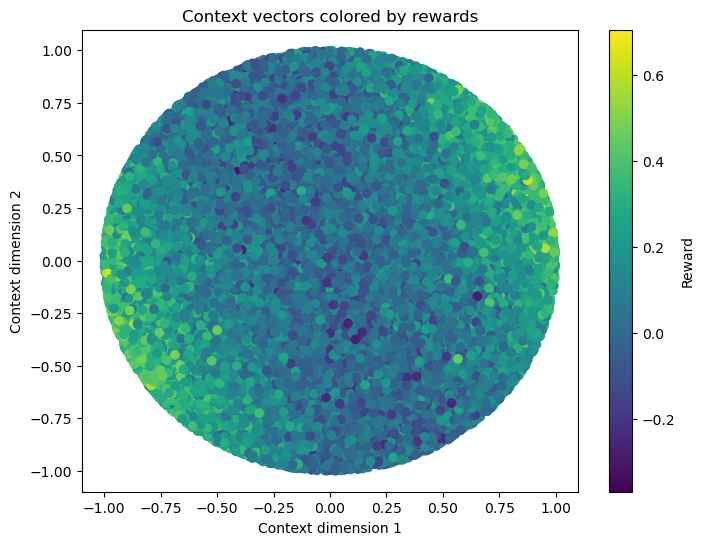

In [29]:
# plot first two dimensions of X and color by y
plt.figure(figsize=(8, 6))
plt.scatter(dataset.contexts.view(-1, dataset.context_size)[:, 0], dataset.contexts.view(-1, dataset.context_size)[:, 1], c=dataset.rewards.view(-1, dataset.context_size)[:], cmap="viridis")
plt.xlabel("Context dimension 1")
plt.ylabel("Context dimension 2")
plt.title("Context vectors colored by rewards")
plt.colorbar(label="Reward")

In [30]:
K = 4

train_loader = DataLoader(dataset, batch_size=1, shuffle=True)
env = BanditBenchmarkEnvironment(train_loader)

buffer = InMemoryDataBuffer(
    buffer_strategy=AllDataBufferStrategy(),
    max_size=None,
)

network = Network(dataset.context_size, hidden_size=100)
# network = LinearNetwork(dataset.context_size)

bandit_module = CombinatorialNeuralUCBBandit(
    n_features=dataset.context_size,
    network=network,
    k=K,
    buffer=buffer,
    train_batch_size=32,
    early_stop_threshold=1e-4,
    weight_decay=1e-3,
    exploration_rate=1,
    learning_rate=1e-4,
    min_samples_required_for_training=10*K,
    initial_train_steps=0,
)

logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)
logging.getLogger("neural_bandits.bandits.abstract_bandit").setLevel(logging.FATAL)
logging.getLogger("neural_bandits.bandits.neural_bandit").setLevel(logging.FATAL)
logger = OnlineBanditLoggerDecorator(
    CSVLogger("logs", name="combinatorial_neural_ucb_bandit", flush_logs_every_n_steps=100),
    enable_console_logging=False
)

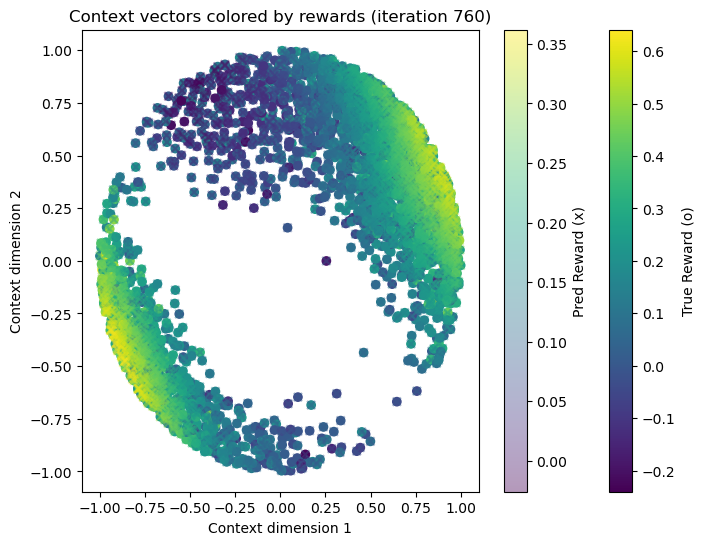

 38%|███▊      | 770/2000 [01:39<02:38,  7.75it/s, acc_regret=313, avg_regret=0.406, regret=0.0623, reward=0.969]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Philipp\\2_uni\\wise2425\\MAB\\neural-bandits\\examples\\plots\\combinatorial_neural_ucb_bandit.png'

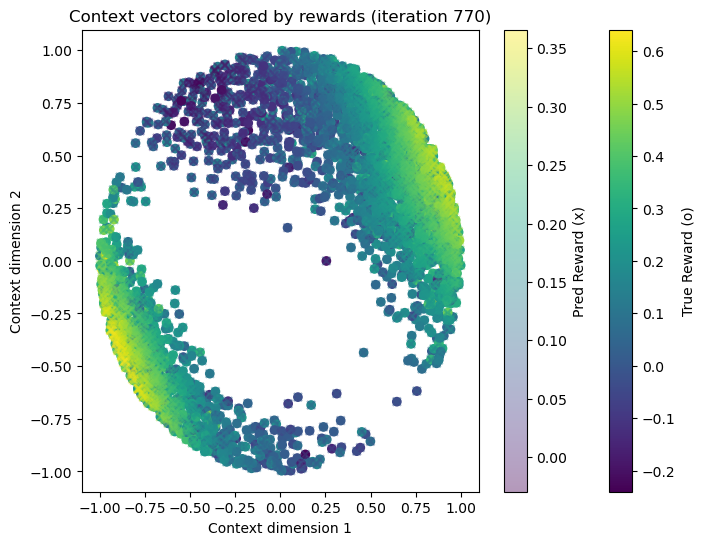

In [ ]:
rewards = np.array([])
regrets = np.array([])
progress_bar = tqdm(enumerate(env), total=len(env))

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter([], [], c=[], cmap="viridis")
cbar = fig.colorbar(scatter, ax=ax, label="True Reward (o)")
cbar2 = fig.colorbar(scatter, ax=ax, label="Pred Reward (x)")

for i, contextualized_actions in progress_bar:
    chosen_actions, _ = bandit_module.forward(contextualized_actions)
    
    trainer = pl.Trainer(
        max_epochs=1,
        max_steps=16,
        logger=logger,
        gradient_clip_val=0.5,
        log_every_n_steps=1,
        enable_progress_bar=False,
        enable_model_summary=False,
        enable_checkpointing=False,
    )
    
    chosen_contextualized_actions, realized_scores = env.get_feedback(chosen_actions)
    realized_rewards = realized_scores.sum(dim=1)
    batch_regret = env.compute_regret(chosen_actions)
    
    rewards = np.append(rewards, realized_rewards.cpu().numpy())
    regrets = np.append(regrets, batch_regret.cpu().numpy())

    progress_bar.set_postfix(
        reward=realized_rewards.mean().item(),
        regret=batch_regret.mean().item(),
        avg_regret=np.mean(regrets),
        acc_regret=np.sum(regrets),
    )
    
    bandit_module.record_feedback(chosen_contextualized_actions, realized_scores)
    trainer.fit(bandit_module)
    
    pred_y = bandit_module.theta_t(buffer.contextualized_actions).detach().numpy()

    if i % 10 == 0:
        # Clear the previous plot
        ax.clear()

        scatter_true = ax.scatter(buffer.contextualized_actions[:, 0, 0], buffer.contextualized_actions[:, 0, 1], c=buffer.rewards, cmap="viridis", marker='o', label='True Rewards', alpha=1.0)

        # plot first two dimensions of X and color by y
        scatter_pred = ax.scatter(buffer.contextualized_actions[:, 0, 0], bandit_module.buffer.contextualized_actions[:, 0, 1], c=pred_y, marker='x', cmap="viridis", alpha=0.4)
        ax.set_xlabel("Context dimension 1")
        ax.set_ylabel("Context dimension 2")
        ax.set_title(f"Context vectors colored by rewards (iteration {i})")
        
        
        cbar.update_normal(scatter_true)
        cbar2.update_normal(scatter_pred)

        # Display the updated plot
        clear_output(wait=True)
        display(fig)

metrics = pd.DataFrame({
    "reward": rewards,
    "regret": regrets,
})

metrics.head()

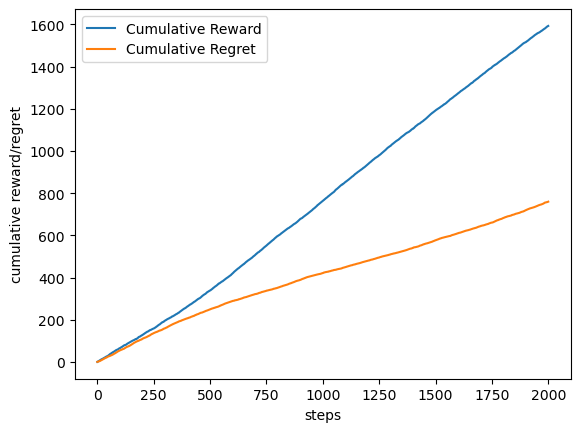

In [ ]:
# Calculate cumulative metrics
cumulative_reward = np.cumsum(metrics["reward"])
cumulative_regret = np.cumsum(metrics["regret"])

# Plot cumulative reward and regret
plt.plot(cumulative_reward, label="Cumulative Reward")
plt.plot(cumulative_regret, label="Cumulative Regret")
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.legend()
plt.show()

In [ ]:
print(f"Average reward (first 10 rounds): {np.mean(metrics['reward'][:10]):.4f}")
print(f"Average reward (first 100 rounds): {np.mean(metrics['reward'][:100]):.4f}")
print(f"Average reward (all rounds): {np.mean(metrics['reward']):.4f}")
print("")
print(f"Average regret (first 10 rounds): {np.mean(metrics['regret'][:10]):.4f}")
print(f"Average regret (first 100 rounds): {np.mean(metrics['regret'][:100]):.4f}")
print(f"Average regret (all rounds): {np.mean(metrics['regret']):.4f}")

Average reward (first 10 rounds): 0.6427
Average reward (first 100 rounds): 0.6523
Average reward (all rounds): 0.7962

Average regret (first 10 rounds): 0.4144
Average regret (first 100 rounds): 0.5460
Average regret (all rounds): 0.3798


logs\combinatorial_neural_ucb_bandit\version_45/metrics.csv


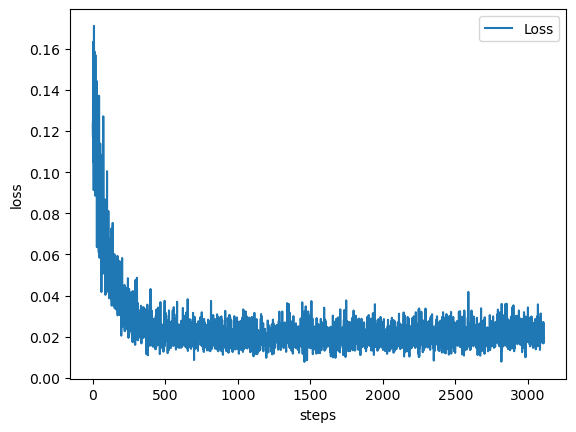

In [ ]:
bandit_metrics_csv = logger._logger_wrappee.log_dir + "/metrics.csv"
print(bandit_metrics_csv)
bandit_metrics = pd.read_csv(bandit_metrics_csv)

plt.plot(bandit_metrics["loss"][:10000].dropna(), label="Loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.show()

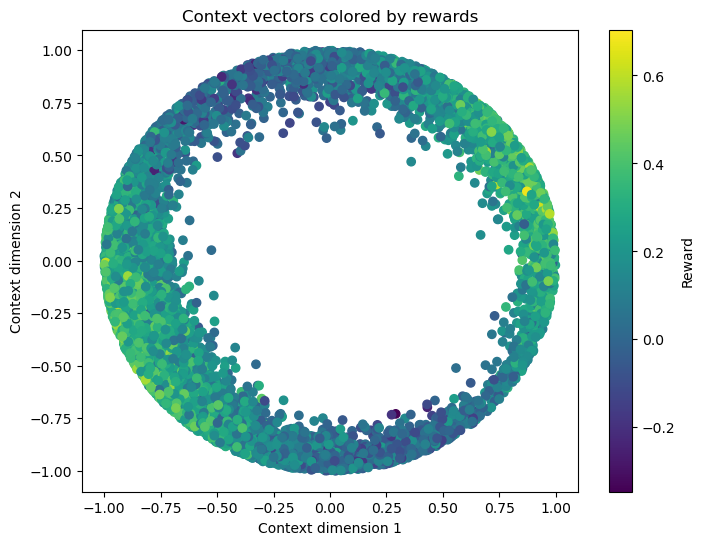

In [ ]:
# plot first two dimensions of X and color by y
plt.figure(figsize=(8, 6))
plt.scatter(bandit_module.buffer.contextualized_actions[:,0, 0], bandit_module.buffer.contextualized_actions[:, 0, 1], c=bandit_module.buffer.rewards, cmap="viridis")
plt.xlabel("Context dimension 1")
plt.ylabel("Context dimension 2")
plt.title("Context vectors colored by rewards")
plt.colorbar(label="Reward")

In [ ]:
dataset.a

tensor([0.5836, 0.2233])

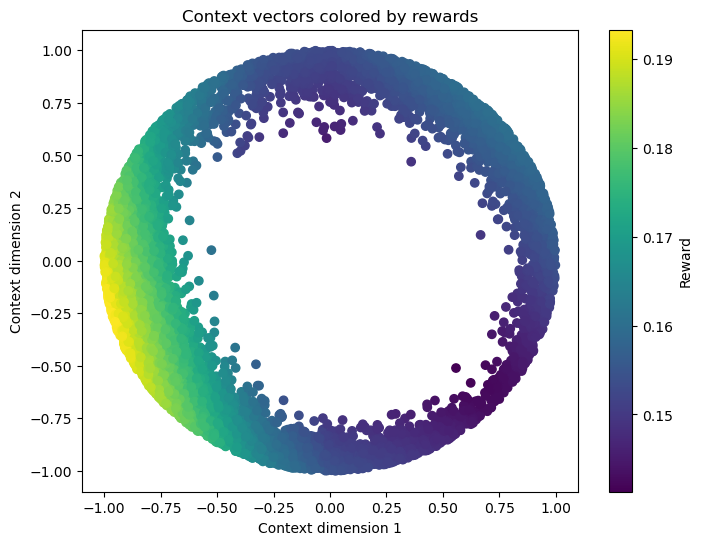

In [ ]:
pred_y = network(buffer.contextualized_actions).detach().numpy()

# plot first two dimensions of X and color by y
plt.figure(figsize=(8, 6))
plt.scatter(buffer.contextualized_actions[:, 0, 0], bandit_module.buffer.contextualized_actions[:, 0, 1], c=pred_y, cmap="viridis")
plt.xlabel("Context dimension 1")
plt.ylabel("Context dimension 2")
plt.title("Context vectors colored by rewards")
plt.colorbar(label="Reward")

Epoch 1, loss: 0.010364710353314877
Epoch 2, loss: 0.00986370537430048
Epoch 3, loss: 0.014141203835606575
Epoch 4, loss: 0.011169190518558025
Epoch 5, loss: 0.0073782033286988735
Epoch 6, loss: 0.006752851884812117
Epoch 7, loss: 0.013774053193628788
Epoch 8, loss: 0.010576952248811722
Epoch 9, loss: 0.012118532322347164
Epoch 10, loss: 0.010089481249451637
Epoch 11, loss: 0.013642434030771255
Epoch 12, loss: 0.007784266024827957
Epoch 13, loss: 0.010730789043009281
Epoch 14, loss: 0.005504542030394077
Epoch 15, loss: 0.009908678941428661
Epoch 16, loss: 0.009715955704450607
Epoch 17, loss: 0.010088629089295864
Epoch 18, loss: 0.008822462521493435
Epoch 19, loss: 0.015713995322585106
Epoch 20, loss: 0.012056315317749977
Epoch 21, loss: 0.007290463428944349
Epoch 22, loss: 0.00770243164151907
Epoch 23, loss: 0.012494845315814018
Epoch 24, loss: 0.011308973655104637
Epoch 25, loss: 0.011763804592192173
Epoch 26, loss: 0.010369443334639072
Epoch 27, loss: 0.009754766710102558
Epoch 28, l

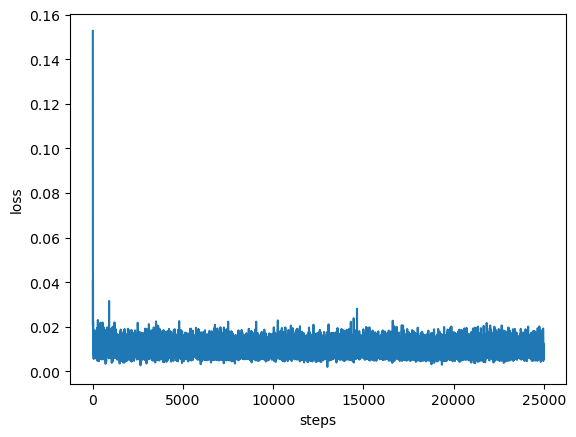

In [ ]:
# Train a neural network on the buffer
network = Network(dataset.context_size, hidden_size=100)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-2)

train_loader = DataLoader(buffer, batch_size=32, shuffle=True)
train_losses = []
for epoch in range(100):
    for contextualized_actions, rewards in train_loader:
        optimizer.zero_grad()
        outputs = network(contextualized_actions)
        loss = criterion(outputs.squeeze(), rewards.squeeze())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}, loss: {loss.item()}")
plt.plot(train_losses)
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()

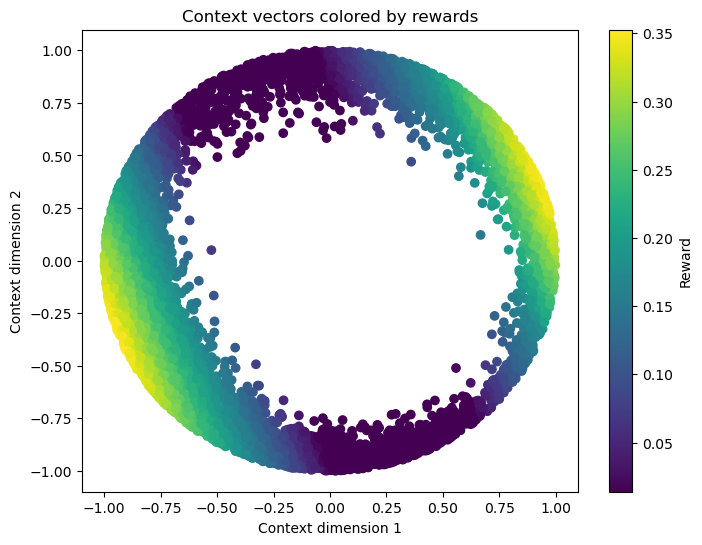

In [ ]:
pred_y = network(buffer.contextualized_actions).detach().numpy().squeeze()

# plot first two dimensions of X and color by y
plt.figure(figsize=(8, 6))
plt.scatter(buffer.contextualized_actions[:, 0, 0], buffer.contextualized_actions[:, 0, 1], c=pred_y, cmap="viridis")
plt.xlabel("Context dimension 1")
plt.ylabel("Context dimension 2")
plt.title("Context vectors colored by rewards")
plt.colorbar(label="Reward")
plt.show()